# Influence Function 線形回帰での例

参考：[Influence Functionでインスタンスの重要度を解釈する - Dropout](https://dropout009.hatenablog.com/entry/2021/07/19/223929)

$$
\begin{align}
L(z, \theta) &= (y - x^\top \theta)^2\\
\nabla_{\theta} L(z, \theta) &= - 2 (y - x^\top \theta) x = -2xy + 2 (x^\top \theta) x\\
R(\theta) &= (y - X\theta)^\top (y - X\theta) \\
\nabla_{\theta} R(\theta) &= -2 X^\top y + 2 (X^\top X) \theta \\
H = \nabla_{\theta}^2 R(\theta) &= 2 (X^\top X)\\
\hat{\theta} &= (X^\top X)^{-1} X^\top y
\end{align}
$$

なので
$$
\begin{align}
\mathcal{I}_{up, params}(z)
    &= -H^{-1}_{\hat{\theta}} \nabla_{\theta} L(z, \hat{\theta})\\
    &= -( 2 X^\top X )^{-1} ( - 2 (y - x^\top \hat\theta) x )
\\
\mathcal{I}_{up, loss}(z, z_{test})
    &= - \nabla_{\theta} L(z_{test}, \hat{\theta})^\top H^{-1}_{\hat{\theta}} \nabla_{\theta} L(z, \hat{\theta}) \\
    &= (2 (y_{test} - x_{test}^\top \hat\theta) x_{test} )^\top ( 2X^\top X )^{-1} ( - 2 (y - x^\top \hat\theta) x )
\end{align}
$$


In [1]:
def influence_params(x, y, X, theta):
    hessian = 2 * (X.T @ X)
    nabla_l_train = - 2 * (y - x.T @ theta) * x
    return np.linalg.inv(hessian) @ nabla_l_train

In [2]:
def influence_loss(x, y, x_test, y_test, X, theta):
    nabla_l_test = (y_test - x_test.T @ theta) * x_test
    hessian = 2 * (X.T @ X)
    nabla_l_train = - 2 * (y - x.T @ theta) * x
    return nabla_l_test.T @ np.linalg.inv(hessian) @ nabla_l_train

In [3]:
import numpy as np

# generate data
n, p = 100, 2
np.random.seed(0)
X = np.random.uniform(size=(n, p))
theta = np.random.uniform(size=p).round(1)
print(theta)
e = np.random.normal(scale=0.1, size=n)
y = X @ theta + e

[0.3 0.7]


In [4]:
class LinearRegression:

    def fit(self, X, y):
        self.theta_ = np.linalg.inv(X.T @ X) @ (X.T @ y)
        return self

    def predict(self, X):
        return X @ self.theta_


In [5]:
# データ全件でのモデル
model = LinearRegression().fit(X, y)
theta_hat = model.theta_
theta_hat

array([0.27816619, 0.71295385])

## Params

### LOO

$$
\hat{\theta}_{-z} - \hat{\theta}
$$

In [6]:
# LOO

diffs = np.array([])
theta_wo_z = np.array([])
for i in range(n):
    X_wo_z = np.concatenate((X[:i, ], X[(i+1):, ]), axis=0)
    y_wo_z = np.concatenate((y[:i], y[(i+1):]), axis=0)
    assert X_wo_z.shape[0] == n - 1
    assert y_wo_z.shape[0] == n - 1
    theta_wo_z_i = LinearRegression().fit(X_wo_z, y_wo_z).theta_
    diff_i = np.linalg.norm(theta_wo_z_i - theta_hat)
    diffs = np.append(diffs, diff_i)
    theta_wo_z = np.concatenate([theta_wo_z, theta_wo_z_i])

theta_wo_z = theta_wo_z.reshape(n, -1)

In [7]:
# LOO (params)

diffs = np.array([])
for i in range(n):
    X_wo_z = np.concatenate((X[:i, ], X[(i+1):, ]), axis=0)
    y_wo_z = np.concatenate((y[:i], y[(i+1):]), axis=0)
    assert X_wo_z.shape[0] == n - 1
    assert y_wo_z.shape[0] == n - 1
    theta_wo_z_i = LinearRegression().fit(X_wo_z, y_wo_z).theta_
    diff_i = np.linalg.norm(theta_wo_z_i - theta_hat)  # ノルムがいいのかはわからんがL2ノルムにしてみる
    diffs = np.append(diffs, diff_i)

In [8]:
diffs_loo = diffs

In [9]:
idxs = np.argsort(diffs)[::-1]
X[idxs][:5]

array([[0.43758721, 0.891773  ],
       [0.0202184 , 0.83261985],
       [0.7936977 , 0.22392469],
       [0.65632959, 0.13818295],
       [0.0641475 , 0.69247212]])

### Influence Function

$$
\mathcal{I}_{up, params}
$$

In [10]:
influence_params(x=X[i], y=y[i], X=X, theta=theta_hat)

array([-0.00253057,  0.00388923])

In [11]:
# influence (params)

diffs = np.array([])
for i in range(n):
    values = influence_params(x=X[i], y=y[i], X=X, theta=theta_hat)
    loo_approx = - (1/n) * values
    diff_i = np.linalg.norm(values)  # ノルムがいいのかはわからんがL2ノルムにしてみる
    diffs = np.append(diffs, diff_i)

diffs_if = diffs
idxs = np.argsort(diffs)[::-1]
X[idxs][:5]

array([[0.43758721, 0.891773  ],
       [0.0202184 , 0.83261985],
       [0.7936977 , 0.22392469],
       [0.65632959, 0.13818295],
       [0.0641475 , 0.69247212]])

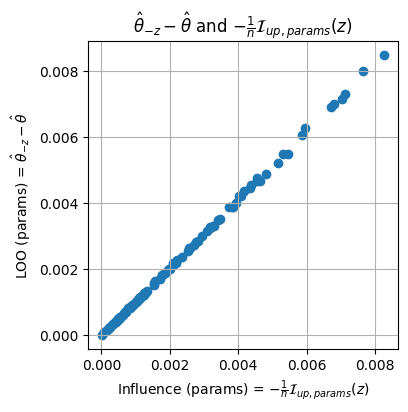

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[4,4])
ax.scatter(diffs_if, diffs_loo)
# ax.set(title="", xlabel="Influence (params)", ylabel="LOO (params)")
# ax.plot(diffs_if, diffs_if, color="gray", alpha=0.5)
ax.set(title=r"$\hat{θ}_{-z} - \hat{θ}$ and $-\frac{1}{n} \mathcal{I}_{up,params}(z)$",
       xlabel=r"Influence (params) = $- \frac{1}{n} \mathcal{I}_{up,params}(z)$",
       ylabel=r"LOO (params) = $\hat{θ}_{-z} - \hat{θ}$")
ax.grid(True)
fig.show()

## Loss

In [13]:
i = 7
X_test = X[[i], ]
y_test = y[i]
X_test

array([[0.07103606, 0.0871293 ]])

In [14]:
def loss(y_pred, y_true):
    return (y_pred - y_true)**2

In [15]:
pred = model.predict(X_test)
loss_original = loss(pred, y_test)
loss_original

array([0.00720099])

### LOO

$$
L(z_{test}, \hat{\theta}_{-z})
- L(z_{test}, \hat{\theta})
$$

In [16]:
# LOO (params)

diffs = np.array([])
for i in range(n):
    X_wo_z = np.concatenate((X[:i, ], X[(i+1):, ]), axis=0)
    y_wo_z = np.concatenate((y[:i], y[(i+1):]), axis=0)
    assert X_wo_z.shape[0] == n - 1
    assert y_wo_z.shape[0] == n - 1
    model_wo_z_i = LinearRegression().fit(X_wo_z, y_wo_z)
    pred_loo = model_wo_z_i.predict(X_test)
    loss_loo = loss(pred_loo, y_test)
    diff_i = loss_loo - loss_original
    diffs = np.append(diffs, diff_i)

In [17]:
diffs_loo = diffs

In [18]:
idxs = np.argsort(diffs)[::-1]
X[idxs][:5]

array([[0.43758721, 0.891773  ],
       [0.72525428, 0.50132438],
       [0.97861834, 0.79915856],
       [0.5759465 , 0.9292962 ],
       [0.34535168, 0.92808129]])

### Influence Function

$$
\mathcal{I}_{up, loss}
$$

In [19]:
# influence (params)

diffs = np.array([])
for i in range(n):
    value = influence_loss(x=X[i], y=y[i], x_test=X_test[0], y_test=y_test, X=X, theta=theta_hat)
    diff_i = - (1/n) * value
    diffs = np.append(diffs, diff_i)

diffs_if = diffs
idxs = np.argsort(diffs)[::-1]
X[idxs][:5]

array([[0.43758721, 0.891773  ],
       [0.72525428, 0.50132438],
       [0.97861834, 0.79915856],
       [0.5759465 , 0.9292962 ],
       [0.34535168, 0.92808129]])

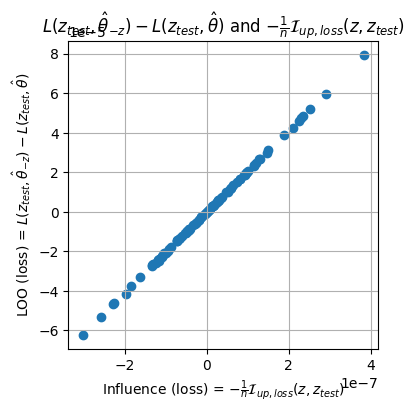

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[4,4])
ax.scatter(diffs_if, diffs_loo)
ax.set(title=r"$L(z_{test}, \hat{θ}_{-z}) - L(z_{test}, \hat{θ})$ and $-\frac{1}{n} \mathcal{I}_{up,loss}(z, z_{test})$",
       xlabel=r"Influence (loss) = $-\frac{1}{n} \mathcal{I}_{up,loss}(z, z_{test})$",
       ylabel=r"LOO (loss) = $L(z_{test}, \hat{θ}_{-z}) - L(z_{test}, \hat{θ})$")
# ax.set(title="", xlabel="Influence (loss)", ylabel="LOO (loss)")
# ax.plot(diffs_if, diffs_if, color="gray", alpha=0.5)
ax.grid(True)
fig.show()